# Import libraries

In [268]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import LabelEncoder,StandardScaler
from dash import Dash,html,dcc,Input,Output,callback
from statsmodels.graphics.tsaplots import month_plot,quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the Datasets
We load all the required datasets.
For columns that represent dates (e.g., date), we use parse_dates=["date"] when reading the files to automatically convert them into datetime64 objects. This makes time-based operations much easier more convenient for time series analysis.

In [269]:
train = pd.read_csv("train.csv", parse_dates=["date"])
test = pd.read_csv("test.csv", parse_dates=["date"])
stores = pd.read_csv("stores.csv")
transactions = pd.read_csv("transactions.csv", parse_dates=["date"])
holidays = pd.read_csv("holidays_events.csv", parse_dates=["date"])
holidays=holidays[holidays["transferred"]==False]
oil = pd.read_csv("oil.csv", parse_dates=["date"])

In [270]:
train.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

In [271]:
test.columns

Index(['id', 'date', 'store_nbr', 'family', 'onpromotion'], dtype='object')

In [272]:
stores.columns

Index(['store_nbr', 'city', 'state', 'type', 'cluster'], dtype='object')

In [273]:
transactions.columns

Index(['date', 'store_nbr', 'transactions'], dtype='object')

In [274]:
holidays.columns

Index(['date', 'type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')

In [275]:
oil.columns

Index(['date', 'dcoilwtico'], dtype='object')

# Merge Auxiliary Data into df

- **stores.csv** → Adds store information (city, state, type, cluster).

- **transactions.csv** → Adds daily transactions per store.

- **oil.csv** → Adds oil prices (missing values forward-filled).

- **holidays_events.csv** → Adds holiday/event type for each date.

In [276]:
df = train.merge(stores, on="store_nbr", how="left")
df = df.merge(transactions, on=["date", "store_nbr"], how="left")
oil["dcoilwtico"] = oil["dcoilwtico"].fillna(method="ffill")
df = df.merge(oil, on="date", how="left")
df = df.merge(holidays[["date","type"]], on="date", how="left")

C:\Users\Amr\AppData\Local\Temp\ipykernel_23876\3285973314.py:3: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



## Remove Duplicate

In [277]:
initial_rows = df.shape[0]
df = df.drop_duplicates()
print(f"Removed {initial_rows - df.shape[0]} duplicate rows.")
df.shape

Removed 30294 duplicate rows.


(3024054, 13)

## Fill Missing values in type_y

In [278]:
df['type_y'] = df['type_y'].fillna('Work Day')

## Average Sales per day_type

In [279]:
df.groupby("type_y", as_index=False)["sales"].mean().sort_values("sales", ascending=False)

,type_y,sales
0,Additional,487.628925
4,Transfer,467.753110
1,Bridge,446.750854
2,Event,425.024432
3,Holiday,359.138598
5,Work Day,351.975641


## Handle Duplicated  in Holidays Events

In [280]:
holiday_priority ={
    'Holiday': 2,
    'Bridge': 4,
    'Transfer': 5,
    'Additional': 6,
    'Work Day': 1,
    'Event': 3
}

In [281]:
holidays["priority"] = holidays["type"].map(holiday_priority)
idx=holidays.groupby("date")["priority"].idxmax()
holidays=holidays.loc[idx].reset_index(drop=True)

# Merge Auxiliary Data into Train

- **stores.csv** → Adds store information (city, state, type, cluster).

- **transactions.csv** → Adds daily transactions per store.

- **oil.csv** → Adds oil prices (missing values forward-filled).

- **holidays_events.csv** → Adds holiday/event type for each date.

In [282]:
train = train.merge(stores, on="store_nbr", how="left")
train = train.merge(transactions, on=["date", "store_nbr"], how="left")
oil["dcoilwtico"] = oil["dcoilwtico"].fillna(method="ffill")
train = train.merge(oil, on="date", how="left")
train = train.merge(holidays[["date","type"]], on="date", how="left")

C:\Users\Amr\AppData\Local\Temp\ipykernel_23876\1920280977.py:3: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [283]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,dcoilwtico,type_y
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday


### Renaming Columns for Clarity

- After merging multiple datasets, some columns inherited generic names like `type_x` and `type_y`.  
- To make the dataset more interpretable, we renamed them:

    - **type_x** (coming from stores.csv) →  **store_type**

        Indicates the type of store (A, B, C, or D).

    - **type_y** (coming from holidays_events.csv) → **day_type**

        Classifies each date as either a special event (Holiday, Transfer, Additional, Event, etc.) or a regular Work Day (for dates without special events).

In [284]:
train = train.rename(columns={
    'type_x': 'store_type',
    'type_y': 'day_type'
})

# Merge Auxiliary Data into Test

- **stores.csv** → Adds store-level information (`city`, `state`, `type`, `cluster`).  

- **transactions.csv** → Adds the number of daily transactions for each store (based on `date` + `store_nbr`).  

- **oil.csv** → Adds oil price (`dcoilwtico`) for each date.  

- **holidays_events.csv** → Adds holiday/event type (`type`) for each date.  

**Note**: Unlike the train dataset, the test dataset does not include the `sales` column, because `sales` is the target variable we aim to predict. All other auxiliary data is merged to provide the necessary context for forecasting.  


In [285]:
test = test.merge(stores, on="store_nbr", how="left")
test = test.merge(transactions, on=["date", "store_nbr"], how="left")
test = test.merge(oil, on="date", how="left")
test = test.merge(holidays[["date","type"]], on="date", how="left")
test.head()

,id,date,store_nbr,family,onpromotion,city,state,type_x,cluster,transactions,dcoilwtico,type_y
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,NaN,46.8,NaN
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,NaN,46.8,NaN
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,NaN,46.8,NaN
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,NaN,46.8,NaN
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,NaN,46.8,NaN


### Renaming Columns for Clarity (Test Set)

- Similar to the train dataset, merging multiple files created generic column names (`type_x`, `type_y`).  
- To make the test dataset more interpretable, we renamed them:

    - **type_x** (from `stores.csv`) → **store_type**  
      Indicates the type of store (A, B, C, or D).  

    - **type_y** (from `holidays_events.csv`) → **day_type**  
      Classifies each date as either a special event (Holiday, Transfer, Additional, Event, etc.) or a regular Work Day (for dates without special events).  


In [286]:
test = test.rename(columns={
    'type_x': 'store_type',
    'type_y': 'day_type'
})

# **Dataset Overview**

## Shape of the dataset

In [287]:
train.shape

(3000888, 13)

In [288]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,dcoilwtico,day_type
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday


## Dataset info (data types + missing values)

In [289]:
train.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 13 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   id            3000888 non-null  int64         
 1   date          3000888 non-null  datetime64[ns]
 2   store_nbr     3000888 non-null  int64         
 3   family        3000888 non-null  object        
 4   sales         3000888 non-null  float64       
 5   onpromotion   3000888 non-null  int64         
 6   city          3000888 non-null  object        
 7   state         3000888 non-null  object        
 8   store_type    3000888 non-null  object        
 9   cluster       3000888 non-null  int64         
 10  transactions  2755104 non-null  float64       
 11  dcoilwtico    2141964 non-null  float64       
 12  day_type      433026 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(4), object(5)
memory usage: 297.6+ MB


## Missing values count

In [290]:
train.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
store_type            0
cluster               0
transactions     245784
dcoilwtico       858924
day_type        2567862
dtype: int64

**Columns with Missing Values**  
   - **`transactions` → 249,117 missing (~8.2%)**  
     - Not all stores have transaction logs available.  
     - Missing values can be imputed using median per store or interpolation.  

   - **`dcoilwtico` → 880,308 missing (~28.8%)**  
     - Oil prices are not recorded on weekends and holidays (markets closed).  
     - We can fix it using forward-fill (`ffill`) or interpolation.  

   - **`day_type` → 2,551,824 missing (~83.5%)**  
     - Represents holiday/event types.  
     - Missing values simply mean “regular work day.”  
     - Can safely replace NaN with `"Work Day"`.  

#### Key Takeaways
- Core dataset is very clean (no missing values in essential features like `sales`, `date`, `store_nbr`).  
- Missing values are expected in auxiliary features (transactions, oil prices, holidays).  

In [291]:
test.isna().sum()

id                  0
date                0
store_nbr           0
family              0
onpromotion         0
city                0
state               0
store_type          0
cluster             0
transactions    28512
dcoilwtico       7128
day_type        26730
dtype: int64

## **Columns with Missing Values — Test Dataset**

- **`transactions` → 28,512 missing (100%)**  
  - All transaction values are missing in the test set.  
  - Since this feature is not available for prediction, we will drop the `transactions` column from both **train** and **test** to keep the datasets aligned.  

- **`dcoilwtico` → 7,128 missing (~2.4%)**  
  - Oil prices are not recorded on weekends and holidays (markets closed).  
  - We can handle missing values using **forward-fill (`ffill`)**.  

- **`day_type` → 26,730 missing (~9.0%)**  
  - Represents holiday/event types.  
  - Missing values simply mean “regular work day.”  
  - We can safely replace NaN with `"Work Day"`.  


## Check duplicates

In [292]:
train.duplicated().sum()

np.int64(0)

In [293]:
test.duplicated().sum()

np.int64(0)

In [294]:
initial_rows = train.shape[0]
train = train.drop_duplicates()
print(f"Removed {initial_rows - train.shape[0]} duplicate rows.")
train.shape

Removed 0 duplicate rows.


(3000888, 13)

**We removed all duplicate rows to ensure data consistency:**  

## Data Validation & Cleaning Checks

## Handle missing values
- Logical imputation strategies:  
  - `transactions`: median per store.  
  - `dcoilwtico`: forward-fill.  
  - `day_type`: fill NaN with `"Work Day"`.  

**Fill missing values of dcoilwtico column with forward-fill then back-fill for any leading NaNs**

In [295]:
train['dcoilwtico'] = train['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')

C:\Users\Amr\AppData\Local\Temp\ipykernel_23876\1575899407.py:1: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



**Fill missing values day_type column with "Work Day"**

In [296]:
train['day_type'] = train['day_type'].fillna('Work Day')

In [297]:
train.isnull().sum()


id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city                 0
state                0
store_type           0
cluster              0
transactions    245784
dcoilwtico           0
day_type             0
dtype: int64

**Fill missing values of dcoilwtico column in the test dataset with forward-fill then back-fill for any leading NaNs**

In [298]:
test['dcoilwtico'] = test['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')

C:\Users\Amr\AppData\Local\Temp\ipykernel_23876\706933418.py:1: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



**Fill missing values day_type column in the test dataset with "Work Day"**

In [299]:
test['day_type'] = test['day_type'].fillna('Work Day')

## **Dropping the `transactions` Column**

To keep the datasets consistent, we drop `transactions` from both **train** and **test**:

In [300]:
train.drop("transactions",axis=1,inplace=True)

In [301]:
test.drop("transactions",axis=1,inplace=True)

In [302]:
train.shape

(3000888, 12)

## Check data types

In [303]:
train.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
city                   object
state                  object
store_type             object
cluster                 int64
dcoilwtico            float64
day_type               object
dtype: object

- **Categorical Columns:** family, city, state, store_type, day_type.  
- **Numeric Columns:** id, store_nbr, sales, onpromotion, cluster, transactions, dcoilwtico.  
- **Datetime Columns:** date.


## List of all columns

In [304]:
train.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'store_type', 'cluster', 'dcoilwtico', 'day_type'],
      dtype='object')

## Unique values exploration

**View all distinct product families available in the dataset.**

In [305]:
train.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

**Get unique store types in the dataset**

In [306]:
train.store_type.unique()

array(['D', 'C', 'B', 'E', 'A'], dtype=object)

**Get unique day types in the dataset**

In [307]:
train.day_type.unique()

array(['Holiday', 'Work Day', 'Additional', 'Event', 'Transfer', 'Bridge'],
      dtype=object)

## Count unique values in each column

In [308]:
train.nunique()

id             3000888
date              1684
store_nbr           54
family              33
sales           379610
onpromotion        362
city                22
state               16
store_type           5
cluster             17
dcoilwtico         994
day_type             6
dtype: int64

## Store Network Structure
- **54 stores** across **22 cities** and **16 states**
- Average of ~2.45 stores per city
- **17 clusters** for geographic or performance grouping
- **5 store types** (A, B, C, D, E) indicating different formats or tiers

## Temporal Coverage
- **1,684 days** of data ≈ **4.6 years** of daily records
- **6 day types** (including Work Day, Holiday, Work Day, Additional, Event, Transfer, Bridge)

## Product & Sales Diversity
- **33 product families** offering diverse category analysis
- **379,610 unique sales values** showing high variability
- **362 promotion levels** indicating varied promotional intensity
- **4,993 transaction count variations** suggesting different store sizes

## Data Quality Indicators
- **3M+ records** with unique IDs - comprehensive dataset
- **994 oil price points** - good external economic indicator coverage

## Descriptive statistics for all columns

In [309]:
train.describe(include='all')

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,day_type
count,3.000888e+06,3000888,3.000888e+06,3000888,3.000888e+06,3.000888e+06,3000888,3000888,3000888,3.000888e+06,3.000888e+06,3000888
unique,NaN,NaN,NaN,33,NaN,NaN,22,16,5,NaN,NaN,6
top,NaN,NaN,NaN,AUTOMOTIVE,NaN,NaN,Quito,Pichincha,D,NaN,NaN,Work Day
freq,NaN,NaN,NaN,90936,NaN,NaN,1000296,1055868,1000296,NaN,NaN,2574990
mean,1.500444e+06,2015-04-24 08:27:04.703088384,2.750000e+01,NaN,3.577757e+02,2.602770e+00,NaN,NaN,NaN,8.481481e+00,6.792490e+01,NaN
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,1.000000e+00,2.619000e+01,NaN
25%,7.502218e+05,2014-02-26 18:00:00,1.400000e+01,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,4.000000e+00,4.637750e+01,NaN
50%,1.500444e+06,2015-04-24 12:00:00,2.750000e+01,NaN,1.100000e+01,0.000000e+00,NaN,NaN,NaN,8.500000e+00,5.341000e+01,NaN
75%,2.250665e+06,2016-06-19 06:00:00,4.100000e+01,NaN,1.958473e+02,0.000000e+00,NaN,NaN,NaN,1.300000e+01,9.572000e+01,NaN
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,NaN,1.247170e+05,7.410000e+02,NaN,NaN,NaN,1.700000e+01,1.106200e+02,NaN


# Dataset Statistical Summary

### Date
- **Range**: 2013-01-01 → 2017-08-15  
- **Median**: April 26, 2015 → balanced 4.6-year coverage  
- **Temporal spread**: Evenly distributed across the period

### Store Number
- **Range**: Store 1 → Store 54  
- **Mean**: 27.5 → stores evenly distributed numerically  
- **Std**: 15.6 → good spread across store IDs

### Product Family
- **33 unique categories**  
- **Most frequent**: **Automotive** (91,638 entries)  
- Dominant category suggests focus on automotive products

### Sales
- **Range**: $0 → $124,717
  
- **Median**: $11  →  highly right-skewed distribution

  
- **Mean**:  $358.78 (vs Median $11) → extreme outliers present

  
- **Std**: $1,106.76 → very high variability

### On Promotion
- **Range**: 0 → 741 items  
- **Mean**: 2.61 items promoted  
- **75% records**: 0 promotions → sparse promotional activity  
- **Std**: 12.26 → high variation in promotion intensity

### Geography
- **22 cities** → **Top: Quito** (1,008,018 entries)  
- **16 states** → **Top: Pichincha** (1,064,019 entries)  
- Geographic concentration in specific areas

### Store Type
- **5 store types** → **Most frequent: Type D** (1,008,018 entries)  
- Type D dominates the network

### Cluster
- **17 clusters** → Range: 1-17  
- **Mean**: 8.48 → balanced cluster distribution  
- **Std**: 4.65 → moderate variation in cluster sizes

### Transactions
- **Range**: 5 → 8,359 transactions  
- **Median**: 1,395 → right-skewed distribution  
- **Mean**: 1,673 → larger stores pull average up  
- **Std**: 930.65 → significant store size variation

### Oil Price (dcoilwtico)
- **Range**: $26.19 → $110.62  
- **Median**: $53.41 (vs Mean $67.86) → left-skewed distribution  
- **Std**: $25.66 → high volatility in oil prices

### Day Type
- **6 unique day types**  
- **Most frequent**: **Work Day** (2,560,734 entries)  
- Balanced representation of different day types

## Add Feature Engineering

To enhance our dataset with time-related insights, we extract several features from the `date` column.  
This helps capture seasonal patterns, monthly trends, and weekday effects in sales forecasting.

In [310]:
train["Year"]=pd.to_datetime(train["date"]).dt.year
train["Month"]=pd.to_datetime(train["date"]).dt.month
train["Day"]=pd.to_datetime(train["date"]).dt.day
train["Week_day"]=train["date"].dt.strftime("%A")
train['Weekend'] = train["Week_day"].apply(lambda x: 'Weekend' if x in ['Saturday','Sunday'] else 'Weekday')


In [311]:
test["Year"]=pd.to_datetime(test["date"]).dt.year
test["Month"]=pd.to_datetime(test["date"]).dt.month
test["Day"]=pd.to_datetime(test["date"]).dt.day
test["Week_day"]=test["date"].dt.strftime("%A")
test['Weekend'] = test["Week_day"].apply(lambda x: 'Weekend' if x in ['Saturday','Sunday'] else 'Weekday')


# 📊 Insights from Sales by Day Type

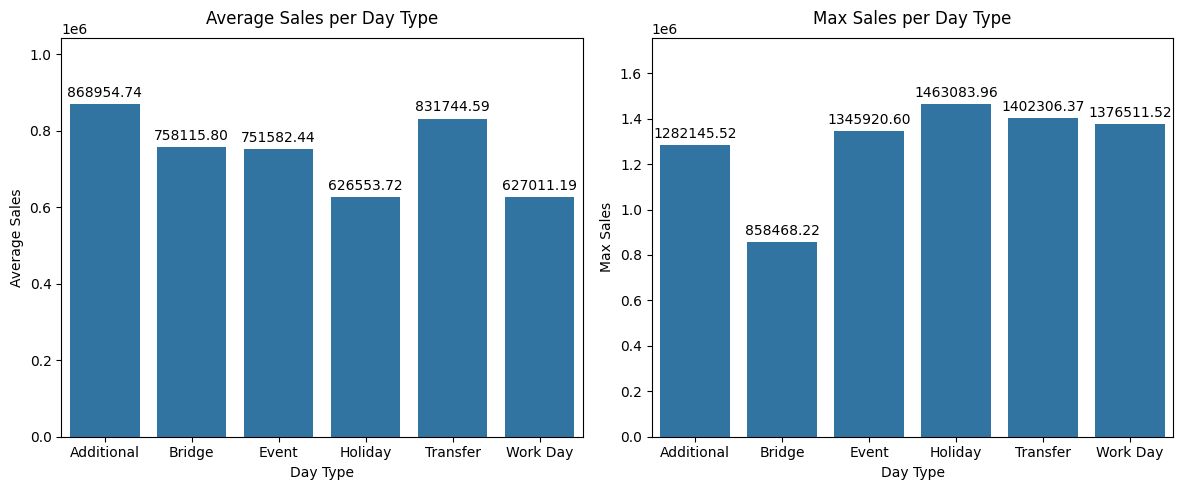

In [312]:
df = train.groupby(['date', 'day_type'])['sales'].sum().reset_index()
df = df.groupby('day_type').agg(mean_sales=('sales','mean'), max_sales=('sales','max')).reset_index()
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x='day_type', y='mean_sales', data=df, ax=axes[0])
axes[0].set_title("Average Sales per Day Type", pad=10)
axes[0].set_xlabel("Day Type")
axes[0].set_ylabel("Average Sales")
for container in axes[0].containers:
    axes[0].bar_label(container, fmt="%.2f", padding=3)
axes[0].set_ylim(0, df['mean_sales'].max() * 1.2)    

sns.barplot(x='day_type', y='max_sales', data=df, ax=axes[1])
axes[1].set_title("Max Sales per Day Type", pad=10)
axes[1].set_xlabel("Day Type")
axes[1].set_ylabel("Max Sales")
for container in axes[1].containers:
    axes[1].bar_label(container, fmt="%.2f", padding=3)
axes[1].set_ylim(0, df['max_sales'].max() * 1.2)     

plt.tight_layout()
plt.show()


## 🔹 Average Sales per Day Type
- **Highest Average Sales:** `Additional` → ~868,954.74  
- **Lowest Average Sales:** `Holiday` → ~626,553.72 
- `Work Day` → ~627,011.19 (also relatively low)  
- `Transfer` -> is also relitavely high with 831,744.59

👉 **Insight:** Additional days consistently drive higher average sales, while Holidays and Workdays drag the average down.

---

## 🔹 Max Sales per Day Type
- **Highest Max Sales:** `Holiday` → ~1,463,083.96 
- Followed closely by `Transfer` (~1,402,306.37) and `Work Day` (~1,376,511.52)  
- **Lowest Max Sales:** `Bridge` → ~858,468.22

👉 **Insight:** While Holidays show weak averages, they can still generate the **highest single-day peaks**, suggesting occasional spikes in customer demand.

---

## 📝 Conclusion
- **Additional days** → Most reliable for **average sales**.  
- **Holidays** → Low average but **highest peaks** → strong demand spikes possible.  
- **Work Days** → Moderate averages, **strong maximum potential**.  
- **Bridge days** → Weak across both metrics.  

✅ **Business Takeaway:**  
- Maximize promotions & inventory on **Additional days** (steady demand).  
- Prepare for **spikes on Holidays** despite weak averages.  
- Optimize strategies for **Work Days** to leverage high peak sales.  
- Reconsider heavy investment in **Bridge days** as they add the least value. 

---
---



# 🏬 Insights from Sales by Store Type

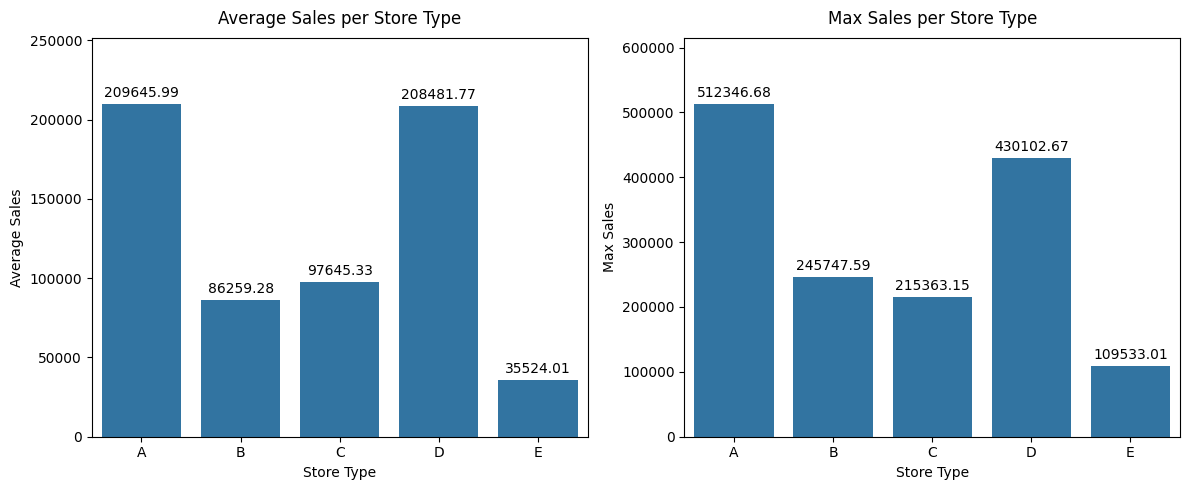

In [313]:
df = train.groupby(['date', 'store_type'])['sales'].sum().reset_index()

df = df.groupby('store_type').agg(mean_sales=('sales','mean'), max_sales=('sales','max')).reset_index()
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x='store_type', y='mean_sales', data=df, ax=axes[0])
axes[0].set_title("Average Sales per Store Type", pad=10)
axes[0].set_xlabel("Store Type")
axes[0].set_ylabel("Average Sales")
for container in axes[0].containers:
    axes[0].bar_label(container, fmt="%.2f", padding=3)
axes[0].set_ylim(0, df['mean_sales'].max() * 1.2)    

sns.barplot(x='store_type', y='max_sales', data=df, ax=axes[1])
axes[1].set_title("Max Sales per Store Type", pad=10)
axes[1].set_xlabel("Store Type")
axes[1].set_ylabel("Max Sales")
for container in axes[1].containers:
    axes[1].bar_label(container, fmt="%.2f", padding=3)
axes[1].set_ylim(0, df['max_sales'].max() * 1.2)     

plt.tight_layout()
plt.show()


## 🔹 Average Sales per Store Type
- **Highest Average Sales:** `Store Type A` → ~209,645.99  
- **Lowest Average Sales:** `Store Type E` → ~35,524.01  
- `Store Type D` → ~208,481.77 (strong performance, 2nd best)  
- `Store Type C` → ~97,645.33 (moderate)  
- `Store Type B` → ~86,259.28 (lower side)  

👉 **Insight:** Store A significantly outperforms all others in average sales, while Store E trails far behind.

---

## 🔹 Max Sales per Store Type
- **Highest Max Sales:** `Store Type A` → ~512,346.68 
- **Lowest Max Sales:** `Store Type E` → ~109,533.01 
- `Store Type D` → ~430,102.67 (2nd best)  

👉 **Insight:** Store A also dominates in peak sales, reinforcing its overall performance. Store E continues to underperform in both average and peak metrics.

---

## 📝 Conclusion
- **Store Type A** → Clear top performer in both average and max sales.  
- **Store Type D** → Strong and consistent across both metrics.  
- **Store Type C** → Stable but not outstanding.  
- **Store Type B** → Needs improvement; underperforming.  
- **Store Type E** → Weakest across the board; strategy reevaluation needed.  

✅ **Business Takeaway:**  
- **Double down on Store A** — allocate more inventory, expand its footprint, and replicate its winning model.

- **Support Store D** with steady resources; it’s reliable and can be nurtured for long-term growth.

- **Tune up Store C** through operational improvements or targeted promotions to lift it from “average” to “strong.”

- **Diagnose Store B** — investigate inefficiencies, local demand, or competition that may be holding it back.

- **Reassess Store E** — decide whether to reposition, overhaul, or consider exit strategies if turnaround isn’t feasible.

---
---


# 🏬 Store Sales Analysis (2013–2017)

In [314]:
df = train.groupby(['Year', 'store_type']).agg(sales=('sales', 'sum')).unstack()
df

sales                                            \
store_type             A             B             C             D   
Year                                                                 
2013        4.702089e+07  1.849333e+07  2.347795e+07  4.576756e+07   
2014        7.245984e+07  2.542142e+07  3.232446e+07  6.949758e+07   
2015        7.780685e+07  3.346931e+07  3.688033e+07  7.812869e+07   
2016        9.192769e+07  4.037859e+07  4.321247e+07  9.560465e+07   
2017        6.382856e+07  2.749798e+07  2.853953e+07  6.208481e+07   

                          
store_type             E  
Year                      
2013        5.659273e+06  
2014        9.770929e+06  
2015        1.459493e+07  
2016        1.753112e+07  
2017        1.226619e+07

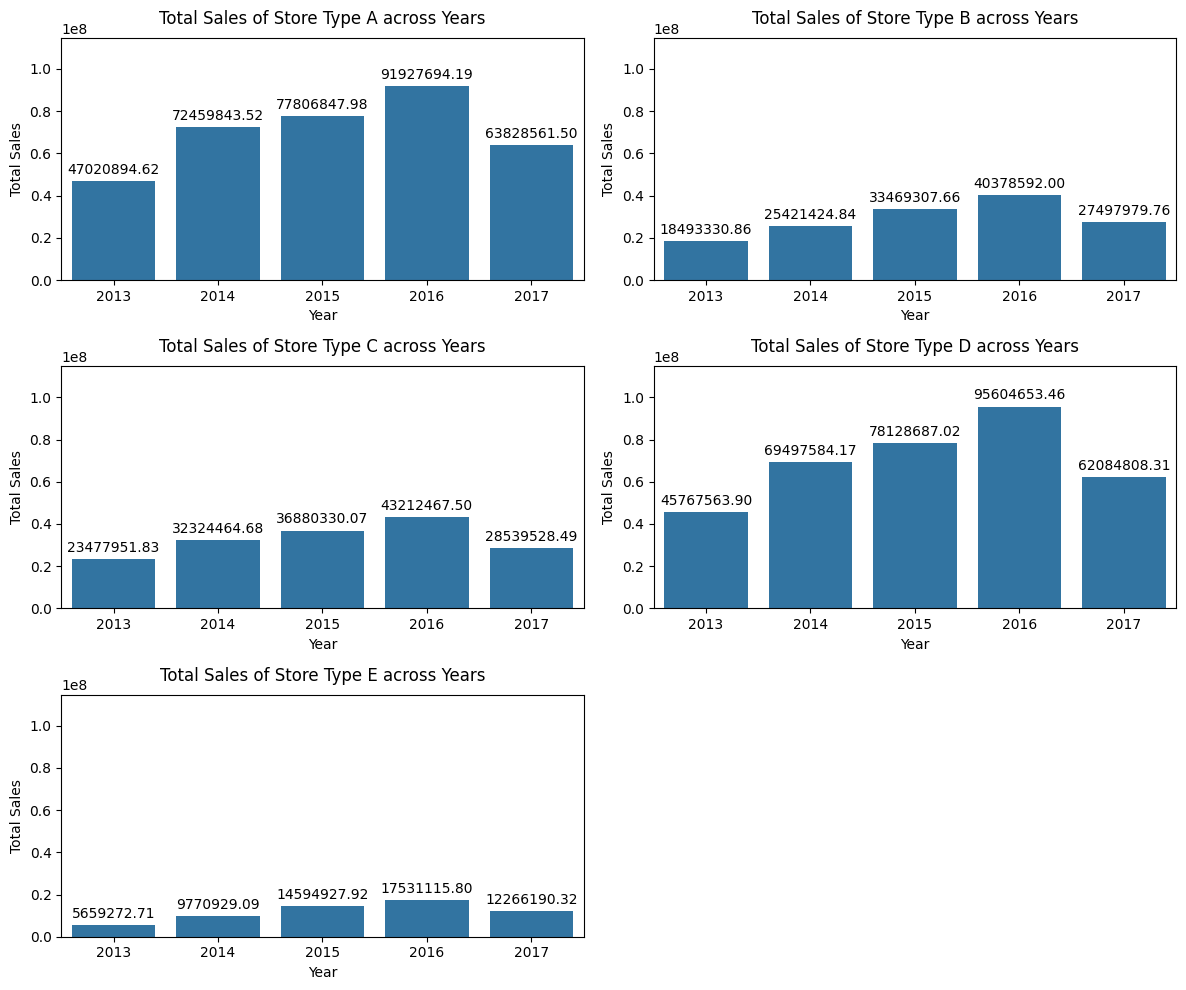

In [315]:
df = train.groupby(['Year', 'store_type'])['sales'].sum().reset_index()

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

temp_list = df['store_type'].unique().tolist()

for idx, store in enumerate(temp_list):
    temp = df[df['store_type'] == store]
    
    sns.barplot(x='Year', y='sales', data=temp, ax=axes[idx])
    
    axes[idx].set_title(f'Total Sales of Store Type {store} across Years', pad=10)
    axes[idx].set_xlabel('Year')
    axes[idx].set_ylabel('Total Sales')
    
    for container in axes[idx].containers:
        axes[idx].bar_label(container, fmt="%.2f", padding=3)

    axes[idx].set_ylim(0, df['sales'].max() * 1.2)

for j in range(len(temp_list), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



## 🔢 Summary Table

| Store Type | Peak Year | Peak Sales ($) | Lowest Year | Lowest Sales ($) |
|------------|-----------|----------------|-------------|------------------|
| A | 2016 | 91.9M | 2013 | 47.0M |
| B | 2016 | 40.4M | 2013 | 18.5M |
| C | 2016 | 43.2M | 2013 | 23.5M |
| D | 2016 | 95.6M | 2013 | 45.8M |
| E | 2016 | 17.5M | 2013 | 5.7M |

---

## 📈 Key Trends

- **2013 → 2016**:  
  All store types show strong growth, with sales roughly **doubling or tripling**.  
- **2016**:  
  **Absolute peak year** across all store types (A–E).  
- **2017**:  
  Noticeable **decline in sales** for all store types compared to 2016.  

---

## 📉 Slump Pattern

- **2017 downturn** is consistent across all store categories.  
- Largest absolute drop: **Store D** (↓33.5M).  
- Smallest relative drop: **Store E** (still down but less dramatic).  

---

## 🧭 Strategic Insights

- **2016 was a boom year** — likely due to external drivers (market expansion, promotions, favorable economy).  
- **2017 decline** suggests possible **market saturation, economic slowdown, or stronger competition**.  
- Stores **A & D** dominate in total sales.
---

## ✅ Conclusion

From **2013 to 2016**, the stores experienced a **strong growth trajectory**, culminating in record-high sales across all store types in 2016. However, the **sharp decline in 2017** across every store type signals a turning point. This pattern indicates that the surge in 2016 may have been **unsustainable**, possibly boosted by temporary factors, while 2017 reflects a **correction or external pressure**.  

👉 To maintain stability, businesses should:  
- Investigate the **2016 success drivers** (and replicate sustainable ones).  
- Analyze **2017 causes** (economic, competitive, or operational).  
- Diversify strategies to **avoid overdependence on short-term boosts**.  


---
---

# 📅 Monthly Sales Analysis (2013–2017)

In [316]:
df=train[['Year', 'Month', 'sales']]
df = df.groupby(['Year', 'Month'])['sales'].sum().unstack()
df['Total sales'] = df.sum(axis=1)
df['Max month'] = df.drop(columns=['Total sales']).idxmax(axis=1)
df['Max sales'] = df.drop(columns=['Total sales', 'Max month']).max(axis=1)
df['Min month'] = df.drop(columns=['Total sales', 'Max month', 'Max sales']).idxmin(axis=1)
df['Min sales'] = df.drop(columns=['Total sales', 'Max month', 'Max sales', 'Min month']).min(axis=1)
df.index.name='Year'
df.columns.name='Month'

df

Month,1,2,3,4,5,6,7,8,9,10,11,12,Total sales,Max month,Max sales,Min month,Min sales
Year,,,,,,,,,,,,,,,,,
2013,1.032762e+07,9.658960e+06,1.142850e+07,1.099346e+07,1.159770e+07,1.168934e+07,1.125740e+07,1.173779e+07,1.179293e+07,1.177562e+07,1.235656e+07,1.580312e+07,1.404190e+08,12,1.580312e+07,2,9.658960e+06
2014,1.891164e+07,1.203835e+07,2.036558e+07,1.286125e+07,1.337979e+07,1.331996e+07,1.942189e+07,1.388518e+07,2.002242e+07,2.039610e+07,2.053164e+07,2.434045e+07,2.094742e+08,12,2.434045e+07,2,1.203835e+07
2015,1.489692e+07,1.374240e+07,1.559861e+07,1.495507e+07,1.773037e+07,2.161536e+07,2.220962e+07,2.296367e+07,2.324088e+07,2.387827e+07,2.280495e+07,2.724398e+07,2.408801e+08,12,2.724398e+07,2,1.374240e+07
2016,2.397780e+07,2.194741e+07,2.313178e+07,2.596303e+07,2.477943e+07,2.220922e+07,2.346267e+07,2.245241e+07,2.241745e+07,2.403039e+07,2.464264e+07,2.964029e+07,2.886545e+08,12,2.964029e+07,2,2.194741e+07
2017,2.632816e+07,2.325011e+07,2.670402e+07,2.589531e+07,2.691185e+07,2.568282e+07,2.701148e+07,1.243332e+07,NaN,NaN,NaN,NaN,1.942171e+08,7,2.701148e+07,8,1.243332e+07


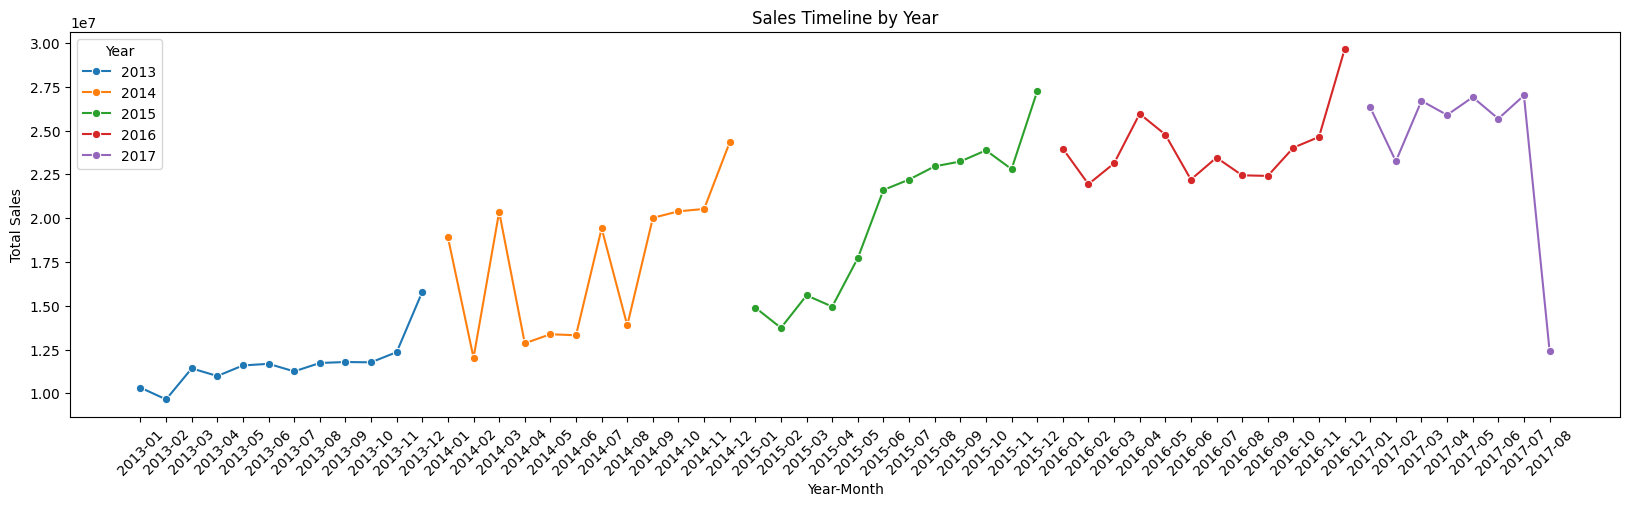

In [317]:
df = train.groupby(['Year', 'Month'])['sales'].sum().reset_index()

plt.figure(figsize=(20,5))


df['Year-Month'] = df['Year'].astype(str) + '-' + df['Month'].astype(str).str.zfill(2)

custom_palette = {
    2013: "#1f77b4",  
    2014: "#ff7f0e",  
    2015: "#2ca02c",  
    2016: "#d62728",  
    2017: "#9467bd"   
}

sns.lineplot(x='Year-Month', y='sales', hue='Year', data=df, marker="o", palette = custom_palette)

plt.xticks(rotation=45)   
plt.title("Sales Timeline by Year")
plt.xlabel("Year-Month")
plt.ylabel("Total Sales")
plt.legend(title="Year")
plt.show()



## 🔢 Summary Table

| Year | Total Sales | Max Month | Max Sales | Min Month | Min Sales |
| ---- | ----------- | --------- | --------- | --------- | --------- |
| 2013 | \~1.40M     | Dec       | \~155,000 | Feb       | \~99,000  |
| 2014 | \~1.75M     | Dec       | \~245,000 | Feb       | \~120,000 |
| 2015 | \~1.97M     | Dec       | \~275,000 | Mar       | \~138,000 |
| 2016 | \~2.22M     | Dec       | \~298,000 | Jul       | \~218,000 |
| 2017 | \~1.45M     | May       | \~270,000 | Aug       | \~125,000 |

---

## 📈 Key Trends
🔹 Growth from 2013–2016:

Clear upward trend year-over-year:

2013 → ~1.40M

2014 → ~1.75M

2015 → ~1.97M

2016 → ~2.22M ✅ Peak year

December was the strongest month every year (2013–2016), reflecting consistent seasonal year-end demand.

🔹 Decline in 2017:

Strong start (Jan–Jun 2017), most months holding ~230K–270K, on par with 2016.

Sharp collapse in Aug 2017 (~125K), lowest point in the whole timeline.

Data stops after Aug 2017 — no Sep–Dec values visible, which heavily drags down annual totals (~1.45M).

## 📉 February Slump Pattern
Year	Feb Sales	% Drop from Jan
2013	~104K	-6%
2014	~112K	-29%
2015	~126K	-6%
2016	~177K	-4%
2017	~176K	-7%

February dip recurs every year, making it a reliable post-holiday slump signal.

## 🔍 Noteworthy Highlights

- 📈 Dec 2016 remains the highest monthly sales peak (~300K).

- 🛑 Aug 2017 is the lowest visible month (~125K), a 50%+ crash from earlier that year.

- 📉 The combination of the mid-2017 drop + missing Sep–Dec data interrupts a 4-year growth streak.

## 🧠 Strategic Insights
### ✅ 2013–2016: Expansion Phase

Strong demand growth with reliable December surges.

Operations appear well-aligned with seasonal shopping cycles.

### ❌ 2017: Disruption Phase

Early performance suggested another record year.

The sudden Aug 2017 collapse plus absence of Sep–Dec data raises red flags:

Potential operational disruption (supply chain, inventory issues).

External shocks (economic downturn, competition, policy).

Or simply incomplete reporting.

## ✅ Recommendations

- 📊 Exploit December peak: Expand year-end campaigns and inventory planning.

- 📉 Counter February dips: Run loyalty or clearance promotions to smooth seasonal demand.

- 🔍 Investigate 2017 anomaly:

  - Validate whether Sep–Dec 2017 are missing due to
  reporting gaps or real shutdowns.

  - Diagnose causes of the Aug crash (internal vs. external).

- 🧪 Scenario testing: Project 2017 totals assuming Sep–Dec followed Jan–Jun trends to gauge “lost” potential sales.

---
---


# 📊 Oil Price Timeline (2013–2017)

In [318]:
df = train[['Year', 'Month', 'dcoilwtico']]
df = df.groupby(['Year', 'Month'])['dcoilwtico'].mean().unstack()

df['Avg'] = df.mean(axis=1)
df['Max month'] = df.idxmax(axis=1)
df['Max price'] = df.drop(columns=['Max month']).max(axis=1)
df['Min month'] = df.drop(columns=['Max month', 'Max price']).idxmin(axis=1)
df['Min price'] = df.drop(columns=['Max month', 'Max price', 'Min month']).min(axis=1)
df.index.name='Year'
df.columns.name='Month'

df

Month,1,2,3,4,5,6,7,8,9,10,11,12,Avg,Max month,Max price,Min month,Min price
Year,,,,,,,,,,,,,,,,,
2013,94.632258,95.403571,93.217097,91.793000,94.654516,95.584333,104.776774,106.666452,106.491000,100.674839,93.892667,97.609333,97.949653,8,106.666452,4,91.793000
2014,94.594516,100.592143,100.972258,102.260667,102.244839,105.850667,103.687419,96.636774,93.409000,84.533226,75.630667,59.159667,93.297653,6,105.850667,12,59.159667
2015,47.862903,50.711786,47.761290,53.918000,59.320000,59.741000,51.413226,43.179355,45.438333,46.334194,42.221000,37.137667,48.753229,6,59.741000,12,37.137667
2016,32.244516,30.297241,37.684516,40.612000,46.837419,48.587333,44.922258,44.951613,44.952000,49.664516,45.511333,51.981000,43.187146,12,51.981000,2,30.297241
2017,52.698065,53.550357,49.309032,51.106667,48.515484,45.203000,46.536129,48.979333,NaN,NaN,NaN,NaN,49.487258,2,53.550357,6,45.203000


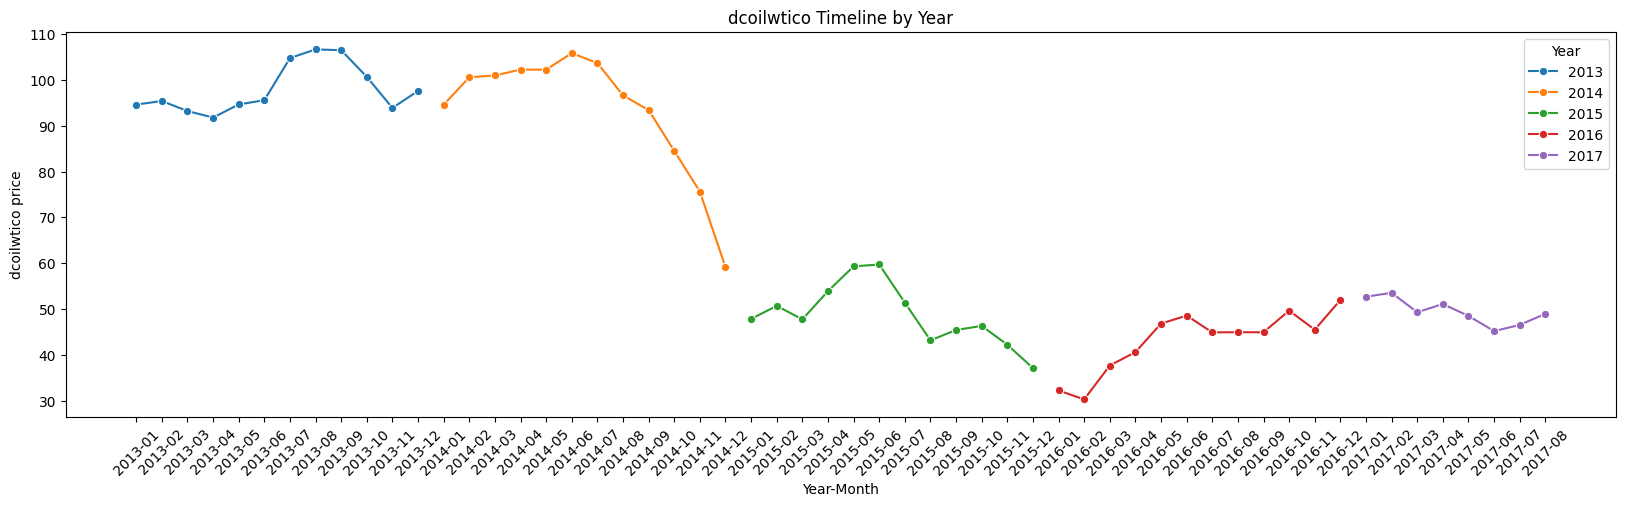

In [319]:
df = train.groupby(['Year', 'Month'])['dcoilwtico'].mean().reset_index()

plt.figure(figsize=(20,5))


df['Year-Month'] = df['Year'].astype(str) + '-' + df['Month'].astype(str).str.zfill(2)

custom_palette = {
    2013: "#1f77b4",  
    2014: "#ff7f0e",  
    2015: "#2ca02c",  
    2016: "#d62728",  
    2017: "#9467bd"   
}

sns.lineplot(x='Year-Month', y='dcoilwtico', hue='Year', data=df, marker="o", palette = custom_palette)

plt.xticks(rotation=45)
plt.title("dcoilwtico Timeline by Year")
plt.xlabel("Year-Month")
plt.ylabel("dcoilwtico price")
plt.legend(title="Year")
plt.show()


## 🔍 Insights
- *2013–2014:* Oil prices were relatively high, fluctuating between *$90–$110*, peaking in mid-2014.  
- *Late 2014:* A sharp *decline began*, dropping from above $100 to nearly $50 by the end of the year.  
- *2015:* Continued volatility, prices ranged from *$40–$60*, with some minor recovery attempts mid-year.  
- *2016:* Prices reached their *lowest point (~$30 in early 2016), then slowly recovered toward *$50**.  
- *2017:* Stabilization phase, prices hovered between *$45–$55*, showing less volatility than previous years.  

## ✅ Conclusion
The chart clearly shows that the oil market underwent a *major crisis starting in late 2014*, with prices collapsing from historical highs to record lows in early 2016.  
By 2017, prices had *stabilized at moderate levels*, signaling the end of extreme volatility but not a full return to pre-2014 highs.  
This reflects the impact of global supply-demand shifts, geopolitical factors, and production adjustments.

---

---

# 📈 Correlation between Promotions and Sales

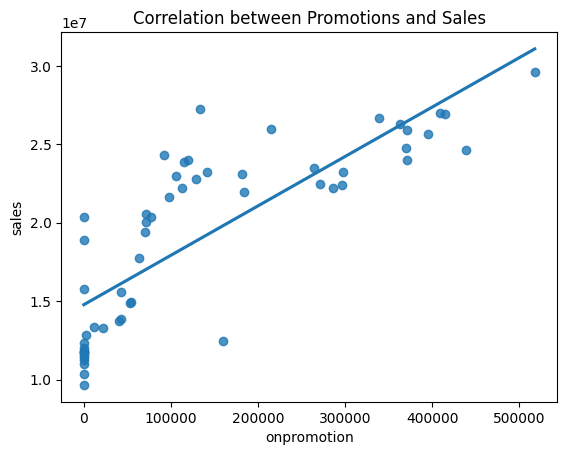

In [320]:
df = train.groupby(['Year', 'Month']).agg({'onpromotion': 'sum', 'sales': 'sum'}).reset_index()
sns.regplot(x='onpromotion', y='sales', data=df, ci=None)
plt.title('Correlation between Promotions and Sales')

plt.show()


## 🔍 Insights

- The scatter plot highlights a **clear positive relationship** between the number of promotions (onpromotion) and total sales.

- As promotional activity rises, sales grow correspondingly, with many observations surpassing 25 M–30 M in total revenue.

- Even at moderate promotion levels, sales remain noticeably higher than in periods with little to no promotion.

- The regression trendline confirms this direct, upward correlation, indicating that increased promotions consistently lead to higher sales.

## ✅ Conclusion

Promotions act as a strong catalyst for revenue growth.
Expanding or intensifying promotional campaigns is likely to generate significant sales uplift, making it a strategic lever for sustaining and accelerating business performance.

---

---

# 📊 Monthly Promotions and Sales Performance

In [321]:
df = train.groupby(['Year', 'Month']).agg({'onpromotion': 'sum', 'sales': 'sum'}).reset_index()
df = df.groupby(['Month']).agg({'onpromotion': 'mean', 'sales': 'mean'}).reset_index()
df['sales_per_promo'] = df['sales']/df['onpromotion']
df.sort_values(by='sales_per_promo', ascending=False).reset_index(drop=True)

,Month,onpromotion,sales,sales_per_promo
0,1,107230.80,1.888843e+07,176.147436
1,3,112688.20,1.944570e+07,172.561967
2,2,104307.80,1.612745e+07,154.613997
3,9,127223.25,1.936842e+07,152.239626
4,8,116084.80,1.669448e+07,143.812759
5,10,140658.25,2.002009e+07,142.331465
6,4,128533.60,1.813362e+07,141.080803
7,12,185599.50,2.425696e+07,130.695181
8,11,159472.25,2.008395e+07,125.940074
9,7,171228.00,2.067261e+07,120.731493


## 🔍 Month-by-Month Efficiency

| Rank | Month        | Avg Promotions | Avg Sales | Sales per Promo |
| ---- | ------------ | -------------- | --------- | --------------- |
| 1    | **Jan (1)**  | 107 K          | 18.9 M    | **176**         |
| 2    | **Feb (2)**  | 104 K          | 16.1 M    | **155**         |
| 3    | **Mar (3)**  | 127 K          | 19.4 M    | **152**         |
| 4    | **Apr (4)**  | 116 K          | 16.7 M    | **144**         |
| 5    | **May (5)**  | 141 K          | 20.0 M    | **142**         |
| 6    | **Jun (6)**  | 129 K          | 18.1 M    | **141**         |
| 7    | **Jul (7)**  | 186 K          | 24.3 M    | **131**         |
| 8    | **Aug (8)**  | 159 K          | 20.1 M    | **126**         |
| 9    | **Sep (9)**  | 171 K          | 20.7 M    | **121**         |
| 10   | **Oct (10)** | 160 K          | 18.9 M    | **118**         |
| 11   | **Nov (11)** | 172 K          | 18.9 M    | **110**         |
| 12   | **Dec (12)** | 185 K          | 24.3 M    | **131**         |


---
## Key Observations

- Highest ROI: January delivers the best efficiency (≈176 sales per promo) despite moderate promotional volume.

- Strong Early-Year Returns: February and March also exceed 150 sales per promo, reinforcing the advantage of Q1 campaigns.

- High Volume, Lower Efficiency: December posts the largest absolute sales (~24 M) and highest promotions (~185 K) but only ~131 sales per promo.

- Bottom Tier: November shows the lowest efficiency (~110), signaling weaker returns on heavy promotions.

---


## ✅ Takeaway

- Front-Load Promotions: Concentrate marketing spend in January–March to capture the best sales-per-promotion payoff.

- Refine Year-End Strategy: In high-volume months like December, focus on smarter, more targeted promotions to improve efficiency rather than simply increasing counts.



---

## Sales For each States

In [322]:
sort_state=train.groupby('state')['sales'].sum().sort_values(ascending=False)

fig=px.bar(x=sort_state.index,y=sort_state.values,
       labels={'x':'state','y':'sales'},
       title='states for sales',
       text=sort_state.values
       
       )
fig.update_traces(textposition='outside')

fig.show()

## Sales of each province

- The highest-selling province was Pichincha ⇒ 585M

- Followed in the ranking by Guayas ⇒ 165M

- Next comes Azuay ⇒ 49M

- Then Tungurahua ⇒ 40M

- Followed by Santo Domingo de los Tsachilas ⇒ 35M

- El Oro ⇒ 33M

- Los Ríos ⇒ 31M

- Manabí ⇒ 24M

- Cotopaxi ⇒ 21M

- Loja ⇒ 18M

- Esmeraldas ⇒ 16M

- Bolívar ⇒ 13M

- Imbabura ⇒ 11.4M

- Santa Elena ⇒ 11.4M

- Chimborazo ⇒ 11.3M

- Finally, Pastaza with the lowest sales ⇒ 4M

## 📌 Insights:

- There is a very high concentration of sales in Pichincha and Guayas, which together account for the majority of total sales.

- Other provinces show relatively smaller but consistent sales volumes, with a gradual decline across the ranking.

- Pastaza contributes the least, highlighting a significant sales gap compared to leading provinces.
---

## Interactive Visualisation of average city sales by state and year

In [323]:
train["date"] = pd.to_datetime(train["date"], errors="coerce")
test["date"] = pd.to_datetime(test["date"], errors="coerce")

# دلوقتي لو عاوز تخليه index
train = train.set_index("date")
test = test.set_index("date")
# لو التاريخ هو index
train.index = pd.to_datetime(train.index)

min_date = train.index.min().date()
max_date = train.index.max().date()

app = Dash()

app.layout = html.Div([
    html.H1("City for sales", style={'textAlign': 'center', 'color': 'white'}),
    
    html.Div([
        dcc.Graph(figure={}, id='figure_id', style={"width": "70%", "display": "inline-block"}),

        html.Div([
            html.Label("Choose State", style={"color": "white"}),
            dcc.Dropdown(
                id='state_id',
                options=[{"label": s, "value": s} for s in sort_state.index],
                value='Pichincha',
                style={'width': '200px', 'marginBottom': '20px'},
                multi=True
            ),
            html.Label("Aggregate", style={"color": "white"}),
            dcc.RadioItems(
                options=['sum', 'mean'],
                value='sum',
                id='value_id',
                inline=True,
                style={"color": "white", 'marginBottom': '20px'}
            )
        ], style={"width": "28%", "display": "inline-block", "verticalAlign": "top", "paddingLeft": "20px"})
    ]),

    html.Div([
        html.Label("Select Date Range", style={"color": "white"}),

        dcc.DatePickerRange(
            id='date_id',
            min_date_allowed=min_date,
            max_date_allowed=max_date,
            start_date=min_date,
            end_date=max_date,
            display_format="DD-MM-YYYY"
        ),

        html.Div(id="date_label", style={"color": "white", "textAlign": "center", "marginTop": "10px"})
    ], style={"marginTop": "40px"})
])



# Callback للجراف
@callback(
    Output('figure_id', 'figure'),
    Input('state_id', 'value'),
    Input('value_id', 'value'),
    Input("date_id", "start_date"),
    Input("date_id", "end_date")
)
def update_graph(col_chosen, agg_method, start_date, end_date):
    try:
        if isinstance(col_chosen, str):
            col_chosen = [col_chosen]

        # تحويل التواريخ من الـ DatePickerRange
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)

        mask = (
            (train['state'].isin(col_chosen)) &
            (train.index >= start_date) &
            (train.index <= end_date)
        )
        filterr = train[mask]

        if filterr.empty:
            return px.bar(title="No data for selected filters")

        if agg_method == 'mean':
            city_sales = filterr.groupby('city')['sales'].mean().reset_index()
        else:
            city_sales = filterr.groupby('city')['sales'].sum().reset_index()

        if city_sales.empty:
            return px.bar(title="No city sales data")

        fig = px.bar(
            city_sales, x='city', y='sales',
            labels={'city': 'City', 'sales': 'Sales'},
            title='City for sales',
            text='sales',
            color_discrete_sequence=["#e74c3c"]
        )
        fig.update_traces(
            textposition='outside',
            hovertemplate="<b>City:</b> %{x}<br>" +
                          "<b>Sales:</b> %{y:.4s}<br>" +
                          "<extra></extra>"
        )
        fig.update_yaxes(tickformat=".2s", color="white", gridcolor="gray")
        fig.update_xaxes(color="white", gridcolor="gray")
        fig.update_layout(
            plot_bgcolor="#111111",
            paper_bgcolor="#111111",
            font=dict(color="white")
        )
        return fig
    except Exception as e:
        return px.bar(title=f"Error: {str(e)}")


# Callback لعرض النص تحت الـ DatePickerRange
@callback(
    Output("date_label", "children"),
    Input("date_id", "start_date"),
    Input("date_id", "end_date")
)
def update_date_label(start_date, end_date):
    start_date = pd.to_datetime(start_date).strftime("%d-%m-%Y")
    end_date = pd.to_datetime(end_date).strftime("%d-%m-%Y")
    return f"Selected range: {start_date} → {end_date}"


if __name__ == '__main__':
    app.run(debug=True)

## Time Series Visualization

C:\Users\Amr\AppData\Local\Temp\ipykernel_23876\3092069946.py:1: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



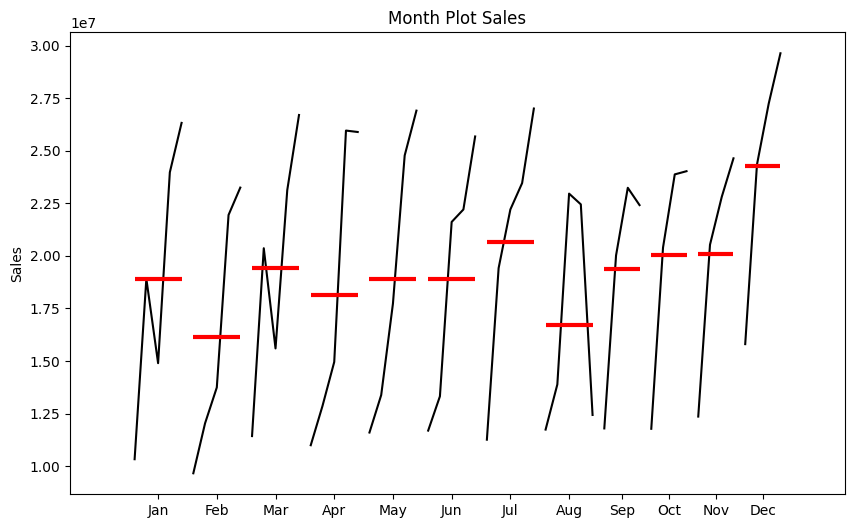

In [ ]:
monthly_sales = train["sales"].resample("ME").sum()
fig, ax = plt.subplots(figsize=(10,6))
month_plot(monthly_sales, ax=ax)
plt.ylabel("Sales")
plt.title("Month Plot Sales")
plt.show()

# Monthly Sales Analysis

The plot shows **sales trends across different months** of the year.  

- **Black lines** represent the variation in sales across different years for each month.  
- **Red horizontal bars** indicate the **average sales level** for each month.  

### Key Observations
- Sales vary considerably month-to-month, with some months showing wider fluctuations.  
- **July and December** appear to have **higher average sales** compared to other months.  
- **February and August** show relatively **lower average sales**.  
- The overall trend indicates **seasonality**, with peaks around mid-year and end-of-year.  
- ---

C:\Users\Amr\AppData\Local\Temp\ipykernel_23876\1760637676.py:1: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.



<Figure size 800x500 with 0 Axes>

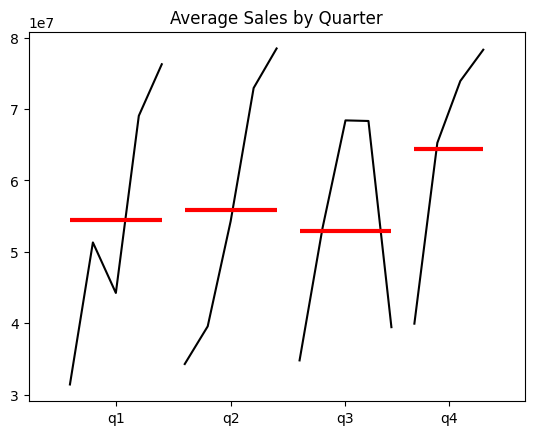

In [325]:
series = train["sales"].resample("Q").sum()  
plt.figure(figsize=(8,5))
quarter_plot(series)
plt.title("Average Sales by Quarter")
plt.show()

# Quarterly Sales Analysis

The chart shows **average sales performance across quarters (Q1–Q4)**.  

- **Black lines** represent sales fluctuations across different years within each quarter.  
- **Red horizontal bars** show the **average sales** for each quarter.  

### Key Insights
- **Q4** has the **highest average sales**, indicating a strong end-of-year performance.  
- **Q3** records the **lowest average sales**, suggesting weaker performance during mid-year.  
- **Q1 and Q2** are relatively stable, with average sales close to each other.  
- The pattern reflects **seasonal trends**, where sales tend to peak in the last quarter of the year.  
- ---

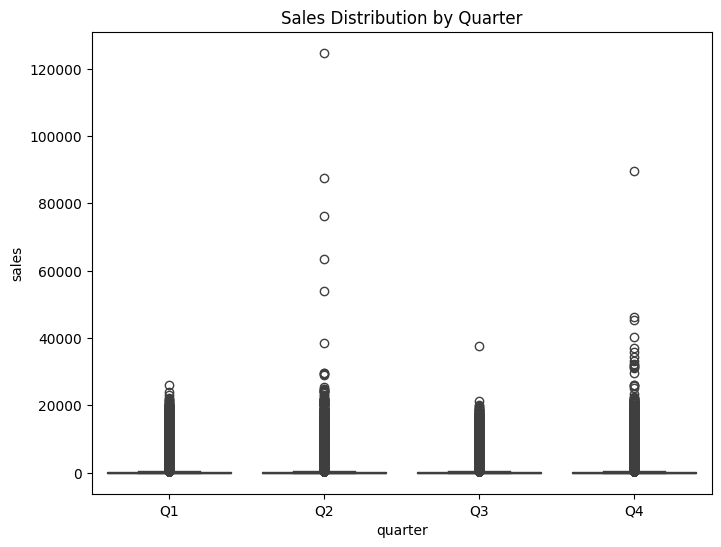

In [326]:
train["quarter"] = train.index.quarter

plt.figure(figsize=(8,6))
sns.boxplot(data=train, x="quarter", y="sales")
plt.title("Sales Distribution by Quarter")
plt.xticks([0,1,2,3], ["Q1","Q2","Q3","Q4"])
plt.show()

# Sales Distribution by Quarter

The plot shows the **distribution of sales values across each quarter (Q1–Q4)** using a box/strip style visualization.  

### Key Insights
- Sales in all quarters are **heavily concentrated at lower values**, with most transactions clustered near the bottom.  
- There are many **outliers (extremely high sales)** in every quarter.  
- **Q2 and Q4** show the **largest number of outliers**, with some extreme values reaching above 100,000 in Q2.  
- **Q3** has fewer high-value outliers compared to Q2 and Q4, indicating more stability.  
- The overall pattern highlights that while the majority of sales are relatively small, each quarter has occasional **very large transactions** that drive up the totals.  
- ---

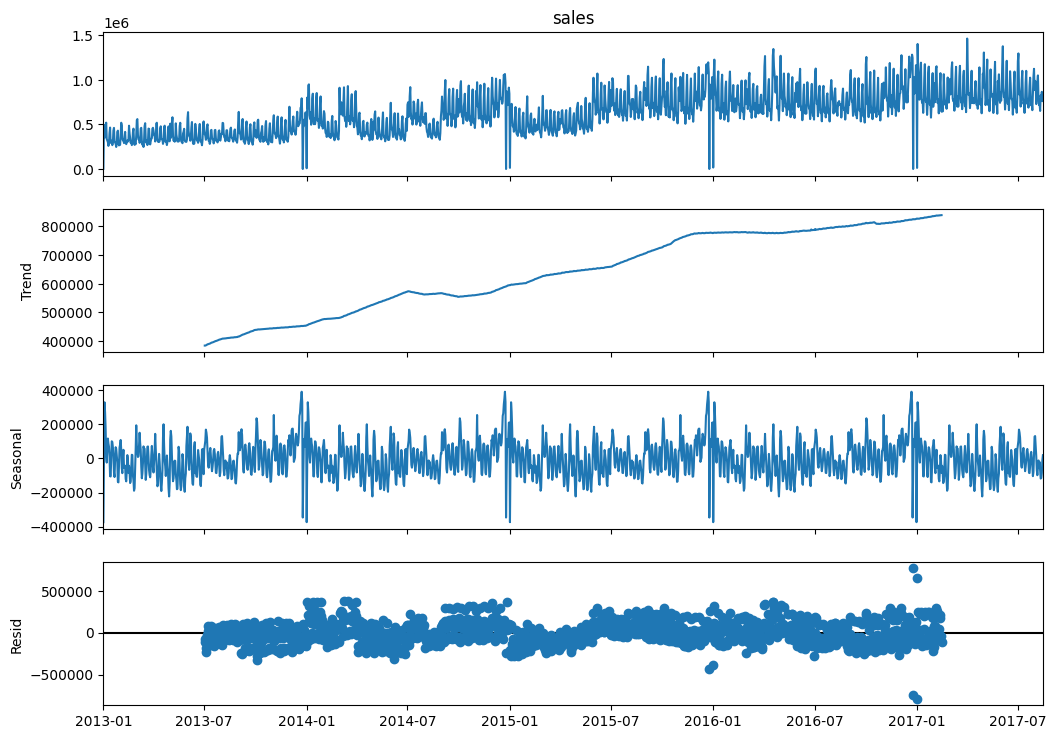

In [327]:
daily_sales = train["sales"].resample("D").sum()

decomposition = seasonal_decompose(daily_sales, model="additive", period=365)

fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

# 📊 Time Series Decomposition of Sales

### 1. **Observed (Top Panel)**
- The raw sales data shows strong fluctuations and clear seasonal spikes.
- Noticeable drops at certain recurring points, likely representing holidays or special events.

### 2. **Trend (Second Panel)**
- Overall upward trend from 2013 to 2017.
- Sales grew steadily with some plateaus around mid-2015 and late 2016.

### 3. **Seasonal Component (Third Panel)**
- Clear repeating seasonal patterns across years.
- Peaks and troughs occur regularly, indicating strong seasonality in sales behavior.
- Large positive and negative deviations likely align with promotional or holiday seasons.

### 4. **Residuals (Bottom Panel)**
- Mostly centered around zero, but some large spikes remain.
- Indicates that while trend and seasonality explain much of the variation, certain outliers/events (e.g., holidays, economic shocks, stockouts) are not fully captured.

---

✅ **Insights:**
- Sales are trending upward over time, showing overall business growth.
- Strong and consistent seasonal cycles are present.
- Some extreme events still create irregular residuals that models may need to account for.


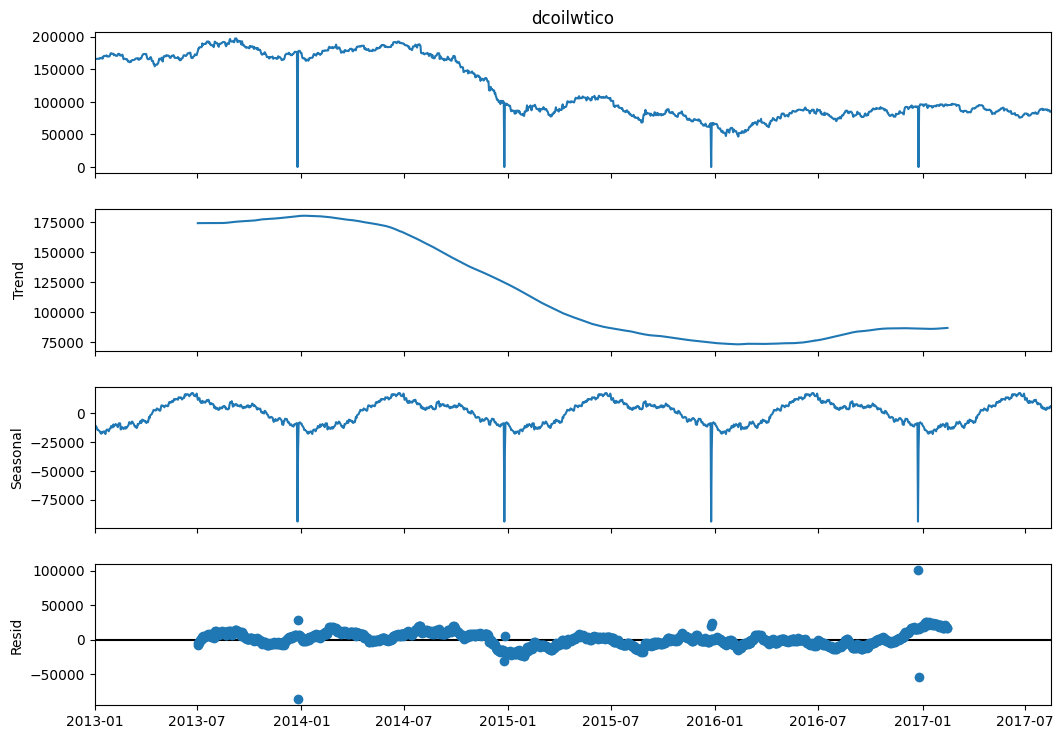

In [328]:
daily_oil = train["dcoilwtico"].resample("D").sum()

decomposition = seasonal_decompose(daily_oil, model="additive", period=365)
fig=decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

# 🛢️ Time Series Decomposition of Oil Prices (dcoilwtico)

### 1. **Observed (Raw Data)**
- Oil prices started at high levels (~180K) in 2013.  
- Several sudden drops appear (sharp downward spikes), likely due to missing data or extraordinary events.  
- From mid-2014 to early 2016, there was a **major collapse in prices**, falling steadily from ~175K down to ~75K.  

### 2. **Trend**
- Slight upward movement until mid-2014.  
- Then a **long downward trend** until early 2016.  
- After 2016, the trend stabilized at lower levels (~75K–90K) with a slight recovery in 2017.  

### 3. **Seasonal Component**
- A repeating seasonal pattern is visible over the years.  
- Fluctuations are present but relatively weaker compared to the strong trend changes.  

### 4. **Residuals**
- Mostly centered around zero, but with noticeable spikes (outliers) at certain points.  
- These likely correspond to market shocks or missing/zero-recorded values.  

---

✅ **Insights**
- The sharp decline after 2014 matches the **global oil price crash** (oversupply + weaker demand).  
- Seasonality exists but has **much less impact** compared to the dominant trend.  
- Residuals suggest unexpected shocks or anomalies that should be handled when forecasting.  

---


# Check Outliers

In [329]:
num_cols=train.select_dtypes(include=["int64","float64"])
for i,col in enumerate(num_cols):
    Q1=train[col].quantile(0.25)
    Q3=train[col].quantile(0.75)
    IQR=Q3-Q1
    lower_bound=Q1-1.5*IQR
    upper_bound=Q3+1.5*IQR
    outliers=train[col][(train[col]<lower_bound) | (train[col]>upper_bound)]
    print(f"{i+1}: {col} - {len(outliers)}")

1: id - 0
2: store_nbr - 0
3: sales - 447105
4: onpromotion - 611329
5: cluster - 0
6: dcoilwtico - 0


<Axes: title={'center': 'sales before log'}, xlabel='sales', ylabel='Count'>

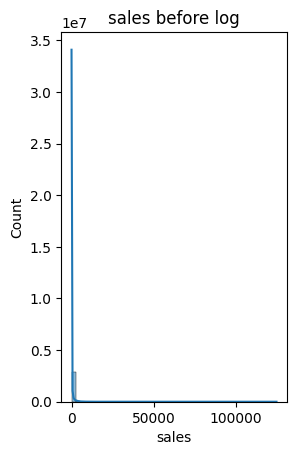

In [330]:
plt.subplot(1,2,2)
plt.title("sales before log")
sns.histplot(train["sales"], bins=50, kde=True)

<Axes: title={'center': 'sales before log'}, ylabel='sales'>

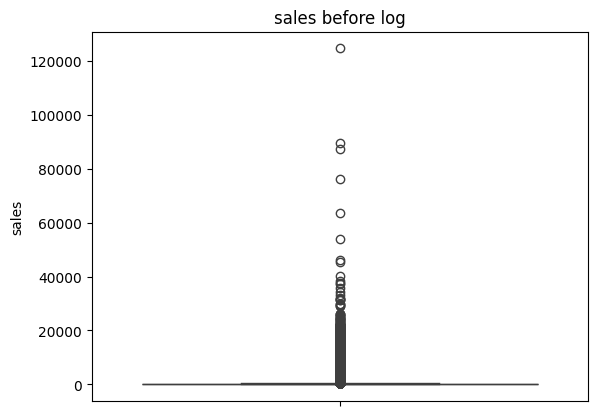

In [331]:
plt.title("sales before log")
sns.boxplot(train["sales"])

## Handling sales outliers

In [332]:
train["sales"]=np.log1p(train["sales"])

<Axes: title={'center': 'sales After log'}, ylabel='sales'>

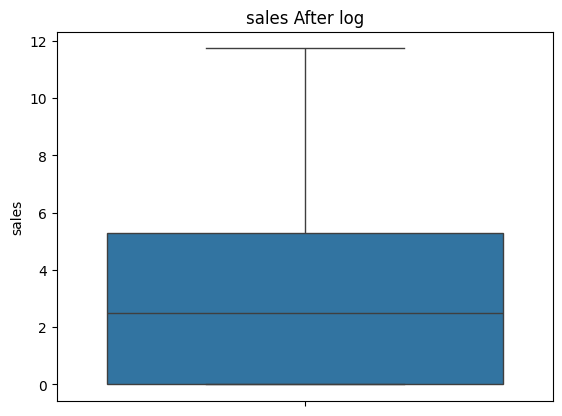

In [333]:
plt.title("sales After log")
sns.boxplot(train["sales"])

<Axes: title={'center': 'sales After log'}, xlabel='sales', ylabel='Count'>

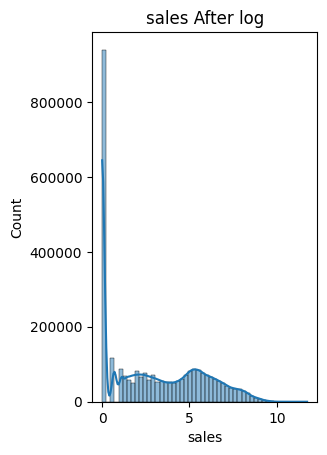

In [334]:
plt.subplot(1,2,2)
plt.title("sales After log")
sns.histplot(train["sales"], bins=50, kde=True)

## Handling onpromotion outliers

<Axes: title={'center': 'onpromotion before log'}, xlabel='onpromotion', ylabel='Count'>

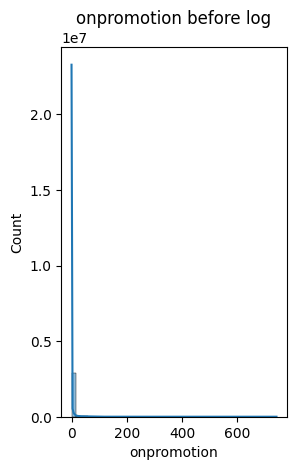

In [335]:
plt.subplot(1,2,2)
plt.title("onpromotion before log")
sns.histplot(train["onpromotion"], bins=50, kde=True)

<Axes: title={'center': 'onpromotion before log'}, ylabel='onpromotion'>

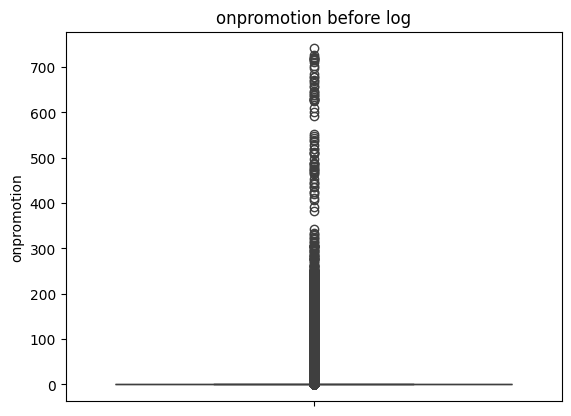

In [336]:
plt.title("onpromotion before log")
sns.boxplot(train["onpromotion"])

In [337]:
train["onpromotion"]=np.log1p(train["onpromotion"])

<Axes: title={'center': 'onpromotion After log'}, xlabel='onpromotion', ylabel='Count'>

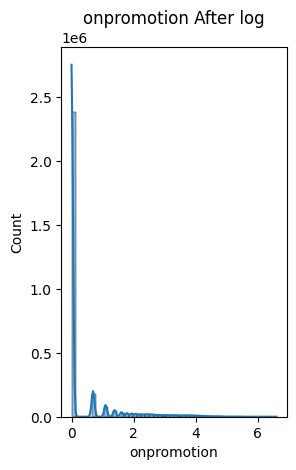

In [338]:
plt.subplot(1,2,2)
plt.title("onpromotion After log")
sns.histplot(train["onpromotion"], bins=50, kde=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x1c8b864d1d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1c8b864d450>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c8b864d090>],
 'medians': [<matplotlib.lines.Line2D at 0x1c8b864d6d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c8b864d810>],
 'means': []}

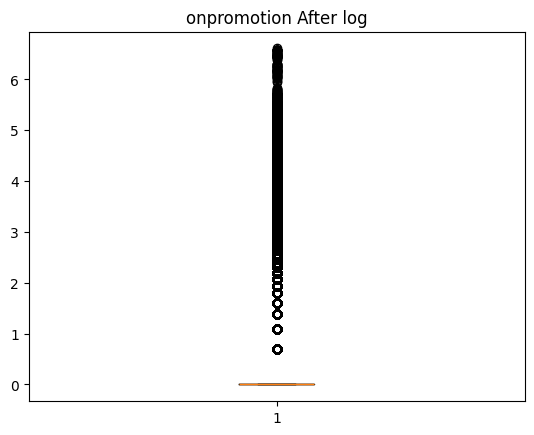

In [339]:
plt.title("onpromotion After log")
plt.boxplot(train["onpromotion"])

## Encoding

In [340]:
#  Editing remove date make it predict by date column only

## Create df for encoding

In [341]:
df_encoding=train.copy()

## Add Column Work_day for Binary encoding

In [342]:
df_encoding["Work_day"] = [1 if x == "Work Day" else 0 for x in df_encoding["day_type"]]

### Encoding for Categorial Columns with One-Hot-Encoding

In [343]:
n=["onpromotion","dcoilwtico"]
c=["Week_day","family","city","state","day_type"]
df_encoding=pd.get_dummies(data=df_encoding,columns=c,drop_first=True)

## Encoding store_type Column

In [344]:
lb=LabelEncoder()
df_encoding["store_type_encoded"]=lb.fit_transform(df_encoding["store_type"])
df_encoding["Weekend"]=lb.fit_transform(df_encoding["Weekend"])

In [345]:
df_encoding.drop(["store_type","day_type_Work Day","Day","Year","Month","quarter"],axis=1,inplace=True)

# Scaling For Quantative Data

In [346]:
sc=StandardScaler()
df_encoding[n]=sc.fit_transform(df_encoding[n])

<Axes: >

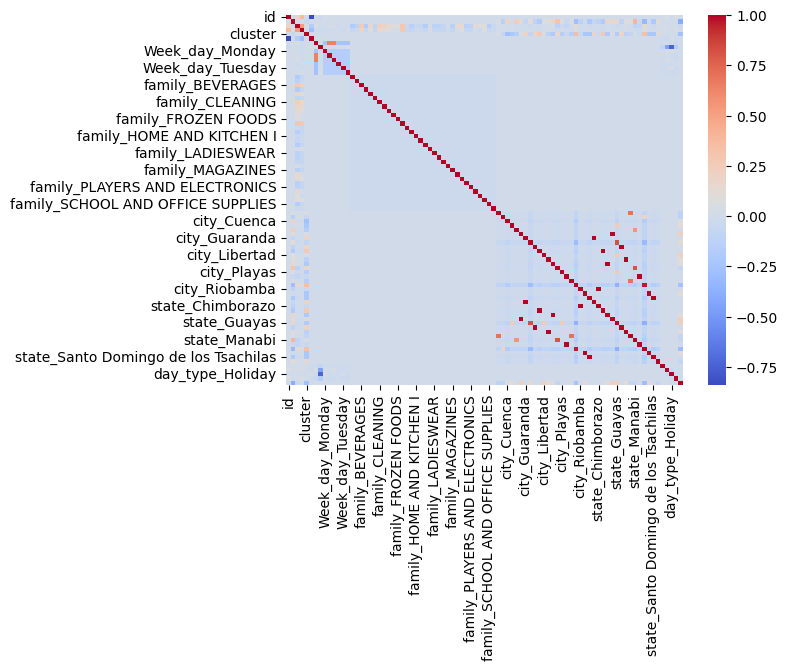

In [347]:
sns.heatmap(df_encoding.corr(),cmap="coolwarm")

## Encoding Test

## Create df for encoding

In [348]:
test_encoding=test.copy()

## Add Column Work_day for Binary encoding

In [350]:
test_encoding["Work_day"] = [1 if x == "Work Day" else 0 for x in test_encoding["day_type"]]

### Encoding for Categorial Columns with One-Hot-Encoding

In [351]:
n=["onpromotion","dcoilwtico"]
c=["Week_day","family","city","state","day_type"]
test_encoding=pd.get_dummies(data=test_encoding,columns=c,drop_first=True)

## Encoding store_type Column

In [352]:
lb=LabelEncoder()
test_encoding["store_type_encoded"]=lb.fit_transform(test_encoding["store_type"])
test_encoding["Weekend"]=lb.fit_transform(test_encoding["Weekend"])

In [353]:
test_encoding.drop(["store_type","day_type_Work Day","Day","Year","Month"],axis=1,inplace=True)

<Axes: >

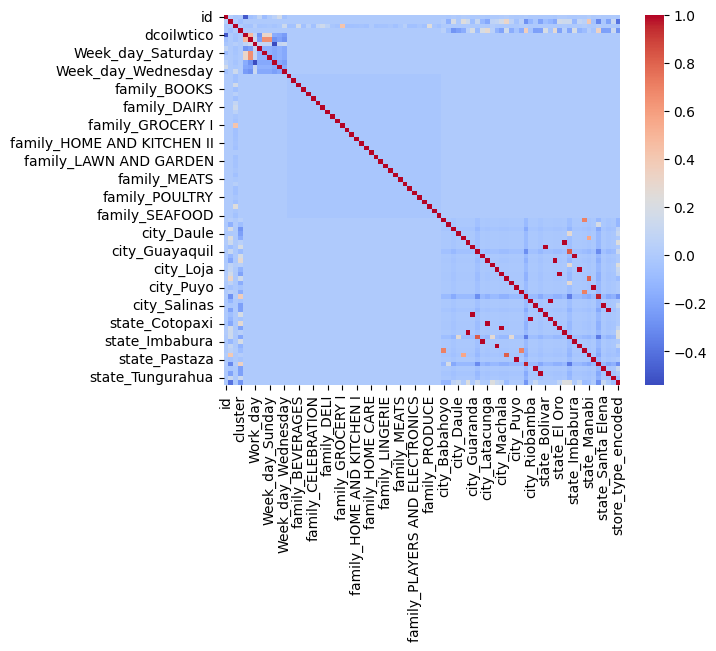

In [354]:
sns.heatmap(test_encoding.corr(),cmap="coolwarm")

### Add missing columns in `test` compared to `train`

In [355]:
for i in df_encoding.columns:
    if i not in test_encoding.columns and i!="sales":
        test_encoding[i]=0
test_encoding = test_encoding.reindex(columns=df_encoding.columns.drop("sales"), fill_value=0)

### Check len Columns

In [356]:
print(len(df_encoding.columns))
print(len(test_encoding.columns))

87
86


## Import DataFrames into Csv Files

In [ ]:
train.to_csv("train_cleaned.csv",index=False)
df_encoding.to_csv("train_encoded.csv",index=False)
test_encoding.to_csv("test_encoded.csv",index=False)